# Homework 2, *part 2*
### (60 points total)

In this part, you will build a convolutional neural network (CNN) to solve (yet another) image classification problem: the Tiny ImageNet dataset (200 classes, 100K training images, 10K validation images). Try to achieve as high accuracy as possible.

**Unlike part 1**, you are now free to use the full power of PyTorch and its subpackages.

## Deliverables

* This file.
* A "checkpoint file" `"checkpoint.pth"` that contains your CNN's weights (you get them from `model.state_dict()`). Obtain it with `torch.save(..., "checkpoint.pth")`. When grading, we will load it to evaluate your accuracy.

**Should you decide to put your `"checkpoint.pth"` on Google Drive, update (edit) the following cell with the link to it:**

### [Dear TAs, I've put my "checkpoint.pth" on Google Drive, download it here](http://your-link-here)

## Grading

* 9 points for reproducible training code and a filled report below.
* 11 points for building a network that gets above 25% accuracy.
* 4 points for using an **interactive** (please don't reinvent the wheel with `plt.plot`) tool for viewing progress, for example Tensorboard ([with this library](https://github.com/lanpa/tensorboardX) and [an extra hack for Colab](https://stackoverflow.com/a/57791702)). In this notebook, insert screenshots of accuracy and loss plots (training and validation) over iterations/epochs/time.
* 6 points for beating each of these accuracy milestones on the private **test** set:
  * 30%
  * 34%
  * 38%
  * 42%
  * 46%
  * 50%
  
*Private test set* means that you won't be able to evaluate your model on it. Rather, after you submit code and checkpoint, we will load your model and evaluate it on that test set ourselves, reporting your accuracy in a comment to the grade.

Note that there is an important formatting requirement, see below near "`DO_TRAIN = True`".

## Restrictions

* No pretrained networks.
* Don't enlarge images (e.g. don't resize them to $224 \times 224$ or $256 \times 256$).

## Tips

* **One change at a time**: never test several new things at once (unless you are super confident). Train a model, introduce one change, train again.
* Google a lot: try to reinvent as few wheels as possible (unlike in part 1 of this assignment).
* Use GPU.
* Use regularization: L2, batch normalization, dropout, data augmentation...
* Pay much attention to accuracy and loss graphs (e.g. in Tensorboard). Track failures early, stop bad experiments early.

In [0]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/Skoltech/Term_4/DL/HW2")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
else:
    AUX_DATA_ROOT = Path(".")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


The below cell puts training and validation images in `./tiny-imagenet-200/train` and `./tiny-imagenet-200/val`:

In [0]:
# Extract the dataset into the current directory
if not Path("tiny-imagenet-200/train/class_000/00000.jpg").is_file():
    import zipfile
    with zipfile.ZipFile(AUX_DATA_ROOT / 'tiny-imagenet-2020.zip', 'r') as archive:
        archive.extractall()

**You are required** to format your notebook cells so that `Run All` on a fresh notebook:
* trains your model from scratch, if `DO_TRAIN is True`;
* loads your trained model from `"./checkpoint.pth"`, then **computes** and prints its validation accuracy, if `DO_TRAIN is False`.

## Train the model

In [0]:
DO_TRAIN = True

### Define start imports & datasets

In [0]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.tensorboard import SummaryWriter
import torch.utils.data as data
import torch.optim as optim

from torchvision import utils
from torchvision import datasets
from torchvision import transforms
import torchvision.transforms.functional as TF

import time
from datetime import datetime

from scipy.ndimage.interpolation import map_coordinates

from torch.optim.lr_scheduler import ReduceLROnPlateau
from pathlib import Path

import os
from IPython.display import clear_output

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(5),
        transforms.RandomAffine(degrees = 10, shear = 10, scale = (0.95, 1.05)),
        transforms.ToTensor(),
        # transforms.Normalize((0.5, 0.5, 0.5), (0.225, 0.225, 0.225))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor()]),
}

In [0]:
data_dir = './tiny-imagenet-200/'
train_dataset = datasets.ImageFolder('{}train'.format(data_dir), transform=data_transforms['train'])
val_dataset   = datasets.ImageFolder('{}val'.format(data_dir), transform=data_transforms['val'])

In [0]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 100000
    Root location: ./tiny-imagenet-200/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-5, 5), resample=False, expand=False)
               RandomAffine(degrees=(-10, 10), scale=(0.95, 1.05), shear=(-10, 10))
               ToTensor()
           )

In [0]:
classes = train_dataset.classes
classes[:10]

['class_000',
 'class_001',
 'class_002',
 'class_003',
 'class_004',
 'class_005',
 'class_006',
 'class_007',
 'class_008',
 'class_009']

In [0]:
batch_size = 128
num_workers = 8
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_dataset, 
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=num_workers)

In [0]:
iter(train_loader).next()[0].shape

torch.Size([128, 3, 64, 64])

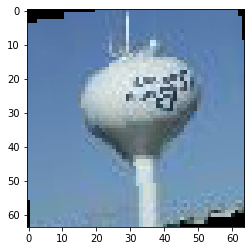

In [0]:
img = iter(train_loader).next()[0][0]
pilTrans = transforms.ToPILImage()
pilImg = pilTrans(img)
plt.imshow(pilImg)

### Tensorboard

In [0]:
# !kill 632
# %reload_ext tensorboard

In [0]:
%load_ext tensorboard
import os
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

### Training

In [0]:
model_num = 0

In [0]:
def train(model, num_epochs, lr=0.1, exp_name='my_network'):
    writer = SummaryWriter('logs/ready_{}'.format(exp_name))
    criterion = torch.nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

    train_loss = []
    train_accuracy = []
    val_accuracy = []

    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch + 1, num_epochs))
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior

        train_accuracy_batch = []

        for batch_no, (X_batch, y_batch) in tqdm(enumerate(train_loader), 
                                                 total=len(train_loader)):
            # main cycle
            model.zero_grad()
            X_batch_gpu = X_batch.to(device)
            preds = model(X_batch_gpu)

            loss = criterion(preds, y_batch.to(device))
            loss.backward()
            opt.step()

            # only for statistics:
            if batch_no % 20 == 0:
                train_loss.append(loss.item())
                writer.add_scalar('train loss', loss.item(), global_step=len(train_loss))

            if batch_no == 0:
                writer.add_graph(model, X_batch_gpu[:8])
        
        train_accuracy = get_accuracy(model, train_loader, device)
        writer.add_scalar('train accuracy', train_accuracy, epoch + 1)

        val_accuracy = get_accuracy(model, val_loader, device)
        writer.add_scalar('val accuracy', val_accuracy, epoch + 1)


        scheduler.step()
        clear_output(wait=True)


    return train_accuracy

def get_accuracy(model, dataloader, device):
    acc = 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)  
            y = y.to(device)  
            prediction = model(X).argmax(dim=-1, keepdim=True)
            acc += prediction.eq(y.view_as(prediction)).sum().item()
    return acc / len(dataloader.dataset) * 100

#### Define own models (implementation famous)

In [0]:
def model_initialize_vgg_f():
    return nn.Sequential(      
        nn.Conv2d(in_channels=3, out_channels=32,kernel_size=2, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(), # 64x64x32

        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(2,1), padding=(1,0)),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), padding=(0,1)),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2), 

        nn.Conv2d(in_channels=32, out_channels=48,kernel_size=2, padding=1),
        nn.BatchNorm2d(48),
        nn.ReLU(),

        nn.Conv2d(in_channels=48, out_channels=48,kernel_size=2, padding=1),
        nn.BatchNorm2d(48),
        nn.ReLU(),

        nn.Conv2d(in_channels=48, out_channels=48,kernel_size=2, padding=1),
        nn.BatchNorm2d(48),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=48, out_channels=64,kernel_size=2, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.Conv2d(in_channels=64, out_channels=64,kernel_size=2, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=64, out_channels=80, kernel_size=2, padding=1),
        nn.BatchNorm2d(80),
        nn.ReLU(),  

        nn.Conv2d(in_channels=80, out_channels=80, kernel_size=2, padding=1),
        nn.BatchNorm2d(80),
        nn.ReLU(),

        nn.Conv2d(in_channels=80, out_channels=80, kernel_size=2, padding=1),
        nn.BatchNorm2d(80),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=80, out_channels=96, kernel_size=2, padding=1),
        nn.BatchNorm2d(96),
        nn.ReLU(),  

        nn.Conv2d(in_channels=96, out_channels=96, kernel_size=2, padding=1),
        nn.BatchNorm2d(96),
        nn.ReLU(),

        nn.Conv2d(in_channels=96, out_channels=96, kernel_size=2, padding=1),
        nn.BatchNorm2d(96),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2),

        nn.Flatten(),
        nn.Linear(1536, 200))

In [0]:
def model_initialize_vgg_19():
    return nn.Sequential(
      
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2), 

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2), 

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2), 


        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2), 

        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),        

        nn.Flatten(),

        nn.Linear(8192, 2048),
        nn.BatchNorm1d(2048),
        nn.ReLU(),
        
        nn.Linear(2048, 2048),
        nn.BatchNorm1d(2048),
        nn.ReLU(),

        nn.Linear(2048, 200))

In [0]:
def model_initialize_vgg_16():
    return nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2), 

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2), 

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2), 


        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2), 

        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Flatten(),

        nn.Linear(8192, 2048),
        nn.ReLU(),

        nn.Linear(2048, 200))

In [0]:
def model_initialize_own1():
    return nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),


        nn.Flatten(),

        nn.Linear(262144, 5000),
        nn.BatchNorm1d(5000),
        nn.ReLU(),

        nn.Linear(5000, 400),
        nn.BatchNorm1d(400),
        nn.ReLU(),
        nn.Linear(400, 200))

In [0]:
def model_initialize_own2():
    return nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64,kernel_size=3 ,stride=1, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=3,padding=1,stride=2),
        nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3 ,stride=1, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.Conv2d(in_channels=128, out_channels=128,kernel_size=3 ,stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.Conv2d(in_channels=128, out_channels=128,kernel_size=3 ,stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.Conv2d(in_channels=128, out_channels=256,kernel_size=3 ,stride=1, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.Conv2d(in_channels=256, out_channels=256,kernel_size=3 ,stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.Conv2d(in_channels=256, out_channels=512,kernel_size=3 ,stride=1, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.AvgPool2d(kernel_size=3, padding=1, stride = 2),
        nn.Flatten(),
        nn.Linear(2048, 1000),
        nn.ReLU(),
        nn.Linear(1000, 200))

#### Define ready models

In [0]:
from torchvision import models
len(classes)

200

##### VGG16

In [0]:
def model_init_vgg16():
    model = models.vgg16(pretrained=False) 
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(classes), bias=True)
    return model

##### ResNet18

In [0]:
def model_init_resnet18():
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, len(classes))
    return model

##### DenseNet

In [0]:
def model_init_densenet121():
    model = models.densenet121(pretrained=False)
    model.classifier = nn.Linear(model.classifier.in_features, len(classes))
    return model


#### Training process

In [0]:
# model = model_initialize_own2()
# model = model_init_resnet18()
# model = model_init_vgg16()
model = model_init_densenet121()
model = model.to(device)
model_num += 1
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [0]:
%%time
DO_TRAIN = True


lr=0.001
exp_name = 'model{}_lr{}'.format(model_num, lr)
if DO_TRAIN:
    print("Train written model")
    tr_accuracy = train(model, num_epochs=21, lr=lr, exp_name=exp_name)

    print("Train accuaracy: {}".format(tr_accuracy))

Train accuaracy: 74.575
CPU times: user 51min 19s, sys: 2min 59s, total: 54min 18s
Wall time: 1h 4min 43s


In [0]:
# Saving model:
torch.save(model.state_dict(), "checkpoint.pth")

In [0]:
from google.colab import files
files.download('checkpoint.pth')

## Load and evaluate the model

In [0]:
DO_TRAIN = False

if not DO_TRAIN:
    model_weights = torch.load("checkpoint.pth", map_location='cpu')
    
    # model_eval = model_initialize_own2()
    # model_eval = model_init_resnet18()
    model_eval = model_init_densenet121()
    model_eval.load_state_dict(model_weights)
    model_eval.to(device)    

    model_eval.train(False)

    val_accuracy = get_accuracy(model_eval, val_loader, device)

    assert 0 <= val_accuracy <= 100
    print("Validation accuracy: %.2f%%" % val_accuracy)

Validation accuracy: 47.20%


# Report

Below, please mention:

* A brief history of tweaks and improvements.
* Which network architectures have you tried? What is the final one and why?
* What is the training method (batch size, optimization algorithm, number of iterations, ...) and why?
* Which techniques have you tried to prevent overfitting? What were their effects? Which of them worked well?
* Any other insights you learned.

For example, start with:

"I have analyzed these and those conference papers/sources/blog posts. \
I tried this and that to adapt them to my problem. \
The conclusions this task taught me are ..."

First of all, I started with looking for work related to the proposed dataset. I found works *(Bastidas, Alexei. "Tiny imagenet image classification." (2017)., Wu, Jiayu, Qixiang Zhang, and Guoxi Xu. Tiny ImageNet challenge. Technical report, Stanford University, 2017. Available online at http://cs231n. stanford. edu/reports/2017/pdfs/930. pdf. Last accessed on 14-06-2019, 2017.)* that examine the effectiveness of implementing VGG-like networks. I implemented three architectures: **VGG-F, VGG16, VGG19**, tried to train DNN, but realized that training works very poorly due to the lack of data augmentation. **Added augmentation** to the training dataset: Flip, Rotation, Affine Transformation. DNN also studied for a long time, so I decided to reduce the number of layers manually, **implemented 2 own architectures**. The first showed terrible results, and **the second** helped to achieve an **accuracy of about 29%** on Validation dataset.

I decided to search for more information and found a great opportunity to use standard architectures from PyTorch Model ZOO. I began to study them in details. To test this feature, I used the ResNet network. The network studied about 30 epochs and achieved an accuracy of 36.43% on Validation dataset. I think this greatly improved my results. However, I did not stop there. I found an article about DenseNet *(Abai, Zoheb, and Nishad Rajmalwar. "DenseNet Models for Tiny ImageNet Classification." arXiv preprint arXiv:1904.10429 (2019).)* and decided to try it on the proposed dataset. The result pleasantly surprised me: I got an **accuracy of about 74.5% on the training** dataset. This was significantly more than previous results. As a result, the final **accuracy on validation data was 47.2%.** I hope that the test sample will not be worse.

PS: **Very pleased with the TensorBoard tool**. He allowed me to interactively monitor the model and stop training when it was necessary. *However*, this tool did not always work correctly, so I had to use Factory Reset.